# FFT - Utilities and Optimization
- **Purpose**: Specialized FFT functions for efficiency and convenience
- **scipy.fft**: rfft, rfftfreq, fftshift, helper functions
- **Optimization**: Real-valued FFTs, zero-padding, windowing

Key topics:
- **rfft**: Real FFT (2x faster for real signals)
- **fftshift/ifftshift**: Rearrange FFT output
- **Zero-padding**: Improve frequency resolution
- **Windowing**: Reduce spectral leakage
- **Performance tips**: FFT size, real vs complex

When to use:
- rfft: Real-valued signals (most signals!)
- Zero-padding: Need finer frequency resolution
- Windows: Reduce artifacts from finite signal length

In [1]:
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt
import time

np.set_printoptions(precision=4, suppress=True)
plt.style.use('seaborn-v0_8-darkgrid')

print("FFT utilities module loaded")

FFT utilities module loaded


## Real FFT (rfft)

**Problem**: Most signals are real-valued (not complex)

**FFT symmetry** for real signals:
- F[k] = F[N-k]* (conjugate symmetry)
- Second half is redundant!

**Solution**: `rfft()` computes only positive frequencies

**Advantages**:
- 2x faster computation
- 2x less memory
- Returns N/2+1 values instead of N

**Usage**:
```python
fft.rfft(signal)      # Real FFT
fft.irfft(F)          # Inverse real FFT
fft.rfftfreq(n, d)    # Frequency array for rfft
```

FFT vs RFFT Comparison
  Signal length: 1000
  Signal is real-valued

Results:
  fft():  1000 complex values, time: 0.398 ms
  rfft(): 501 complex values, time: 0.058 ms

Speedup: 6.9x faster
Memory: 2.0x less

Frequency arrays:
  fftfreq():  [0.0, ..., -1.0] Hz
  rfftfreq(): [0.0, ..., 500.0] Hz
  rfftfreq only returns non-negative frequencies!


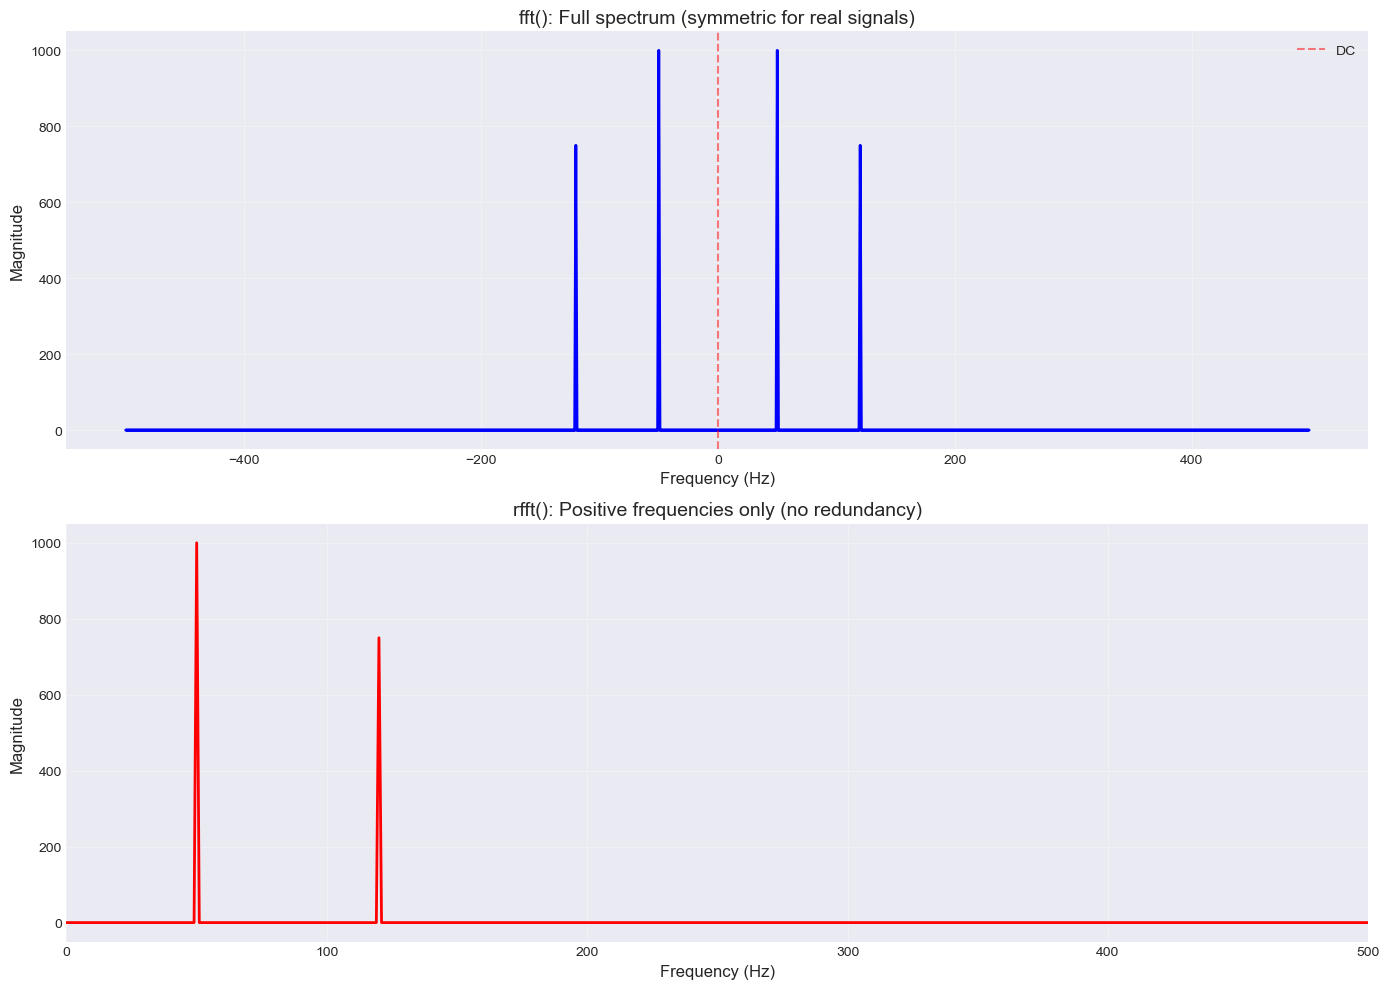


For real signals, always use rfft() for better performance!


In [2]:
# Create real signal
sample_rate = 1000
duration = 1.0
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
signal = 2*np.sin(2*np.pi*50*t) + 1.5*np.sin(2*np.pi*120*t)

N = len(signal)

# Compare fft vs rfft
print("FFT vs RFFT Comparison")
print(f"  Signal length: {N}")
print(f"  Signal is real-valued\n")

# Regular FFT
t0 = time.time()
fft_result = fft.fft(signal)
time_fft = time.time() - t0

# Real FFT
t0 = time.time()
rfft_result = fft.rfft(signal)
time_rfft = time.time() - t0

print("Results:")
print(f"  fft():  {len(fft_result)} complex values, time: {time_fft*1000:.3f} ms")
print(f"  rfft(): {len(rfft_result)} complex values, time: {time_rfft*1000:.3f} ms")
print(f"\nSpeedup: {time_fft/time_rfft:.1f}x faster")
print(f"Memory: {len(fft_result)/len(rfft_result):.1f}x less")

# Frequency arrays
freqs_fft = fft.fftfreq(N, 1/sample_rate)
freqs_rfft = fft.rfftfreq(N, 1/sample_rate)

print(f"\nFrequency arrays:")
print(f"  fftfreq():  [{freqs_fft[0]:.1f}, ..., {freqs_fft[-1]:.1f}] Hz")
print(f"  rfftfreq(): [{freqs_rfft[0]:.1f}, ..., {freqs_rfft[-1]:.1f}] Hz")
print(f"  rfftfreq only returns non-negative frequencies!")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# FFT (full)
axes[0].plot(freqs_fft, np.abs(fft_result), 'b-', linewidth=2)
axes[0].axvline(0, color='r', linestyle='--', alpha=0.5, label='DC')
axes[0].set_xlabel('Frequency (Hz)', fontsize=12)
axes[0].set_ylabel('Magnitude', fontsize=12)
axes[0].set_title('fft(): Full spectrum (symmetric for real signals)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RFFT (positive only)
axes[1].plot(freqs_rfft, np.abs(rfft_result), 'r-', linewidth=2)
axes[1].set_xlabel('Frequency (Hz)', fontsize=12)
axes[1].set_ylabel('Magnitude', fontsize=12)
axes[1].set_title('rfft(): Positive frequencies only (no redundancy)', fontsize=14)
axes[1].set_xlim(0, sample_rate/2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFor real signals, always use rfft() for better performance!")

## FFT Shift: fftshift() and ifftshift()

**Problem**: FFT output has DC component at index 0
- Frequencies: [0, 1, 2, ..., N/2-1, -N/2, ..., -2, -1]
- Awkward for visualization and filtering

**Solution**: `fftshift()` rearranges to centered format
- Frequencies: [-N/2, ..., -2, -1, 0, 1, 2, ..., N/2-1]
- DC (zero frequency) moves to center

**Inverse**: `ifftshift()` undoes the shift before IFFT

**Use case**: Filtering, visualization, analysis

FFT Shift Demonstration

Original frequency order (fftfreq):
  [ 0.      0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375 -0.5
 -0.4375 -0.375  -0.3125 -0.25   -0.1875 -0.125  -0.0625]

Shifted frequency order (fftshift):
  [-0.5    -0.4375 -0.375  -0.3125 -0.25   -0.1875 -0.125  -0.0625  0.
  0.0625  0.125   0.1875  0.25    0.3125  0.375   0.4375]

DC component moved from index 0 to center!

Round-trip test:
  Original == ifftshift(fftshift(original)): True


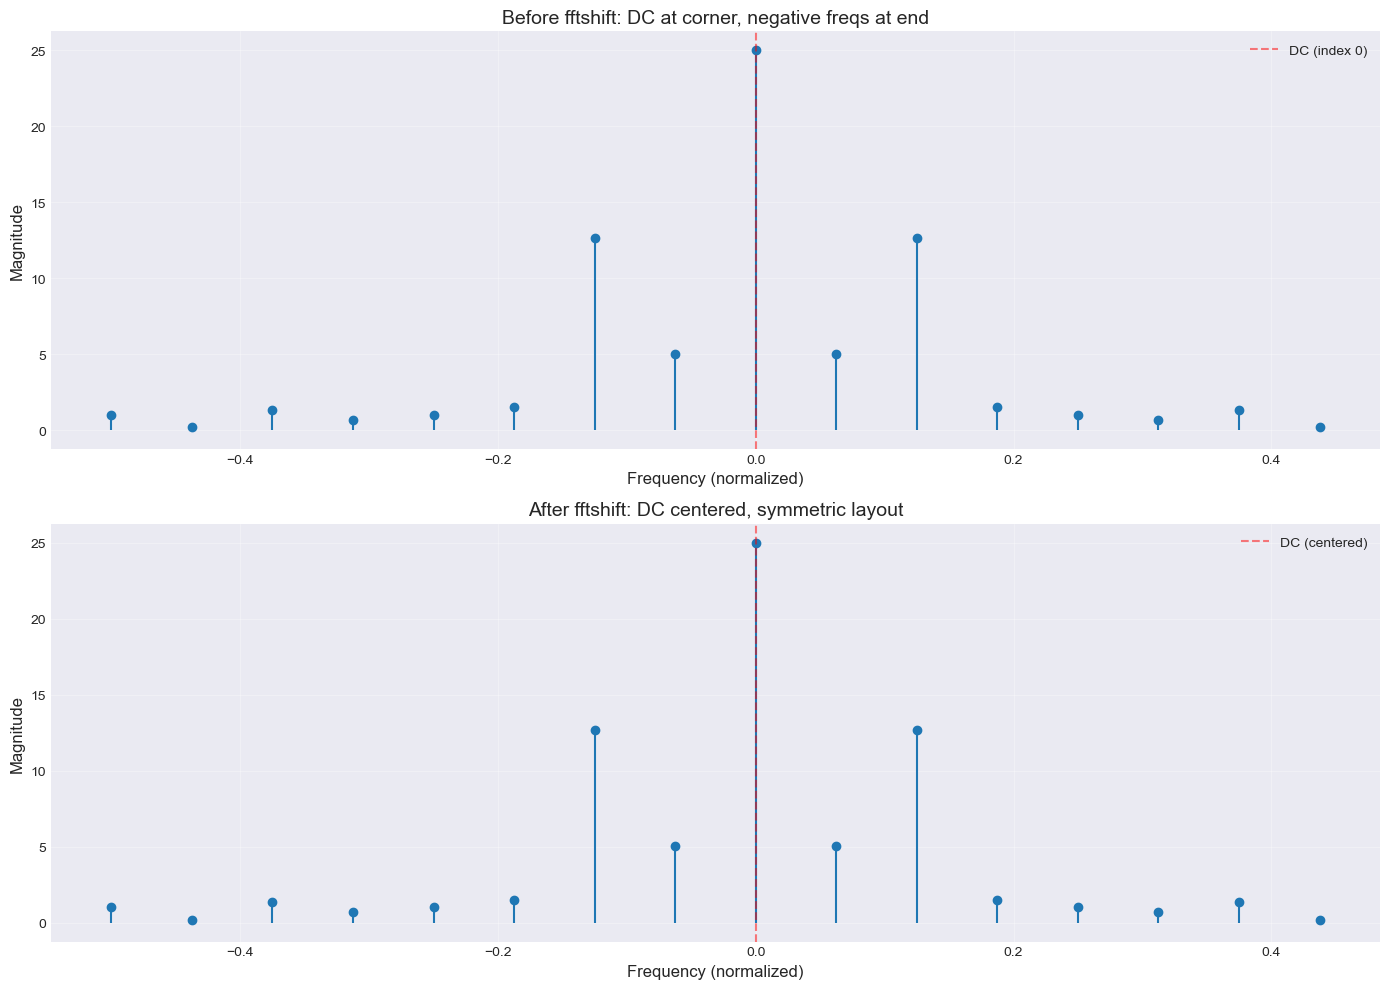


fftshift makes frequency domain easier to visualize and filter!


In [3]:
# Create signal
N = 16
signal = np.array([1, 2, 3, 4, 3, 2, 1, 0, 0, 1, 2, 3, 2, 1, 0, 0])

# FFT
fft_result = fft.fft(signal)
freqs = fft.fftfreq(N)

# Shifted FFT
fft_shifted = fft.fftshift(fft_result)
freqs_shifted = fft.fftshift(freqs)

print("FFT Shift Demonstration")
print(f"\nOriginal frequency order (fftfreq):")
print(f"  {freqs}")
print(f"\nShifted frequency order (fftshift):")
print(f"  {freqs_shifted}")
print(f"\nDC component moved from index 0 to center!")

# Verify round-trip
fft_unshifted = fft.ifftshift(fft_shifted)
print(f"\nRound-trip test:")
print(f"  Original == ifftshift(fftshift(original)): {np.allclose(fft_result, fft_unshifted)}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Before shift
axes[0].stem(freqs, np.abs(fft_result), basefmt=' ')
axes[0].axvline(0, color='r', linestyle='--', alpha=0.5, label='DC (index 0)')
axes[0].set_xlabel('Frequency (normalized)', fontsize=12)
axes[0].set_ylabel('Magnitude', fontsize=12)
axes[0].set_title('Before fftshift: DC at corner, negative freqs at end', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After shift
axes[1].stem(freqs_shifted, np.abs(fft_shifted), basefmt=' ')
axes[1].axvline(0, color='r', linestyle='--', alpha=0.5, label='DC (centered)')
axes[1].set_xlabel('Frequency (normalized)', fontsize=12)
axes[1].set_ylabel('Magnitude', fontsize=12)
axes[1].set_title('After fftshift: DC centered, symmetric layout', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nfftshift makes frequency domain easier to visualize and filter!")

## Zero-Padding: Improve Frequency Resolution

**Problem**: Frequency resolution = sample_rate / N
- Short signals → poor resolution
- Can't distinguish close frequencies

**Solution**: Zero-padding (add zeros to end)
- Increases N → better resolution
- **Does NOT** add information!
- Interpolates FFT (smoother spectrum)

**Usage**:
```python
fft.fft(signal, n=padded_length)
```

**Benefits**:
- Smoother spectrum plots
- Better peak localization
- Easier to identify frequencies

**Note**: FFT fastest when N is power of 2

Zero-Padding for Better Resolution
  Signal length: 100 samples
  Duration: 0.1 s
  Frequencies: 45 Hz and 55 Hz (10 Hz apart)
  Original resolution: 10.0 Hz

Padding factor 1x:
  Length: 100
  Resolution: 10.00 Hz
  Can separate 45 and 55? False

Padding factor 4x:
  Length: 400
  Resolution: 2.50 Hz
  Can separate 45 and 55? True

Padding factor 16x:
  Length: 1600
  Resolution: 0.62 Hz
  Can separate 45 and 55? True



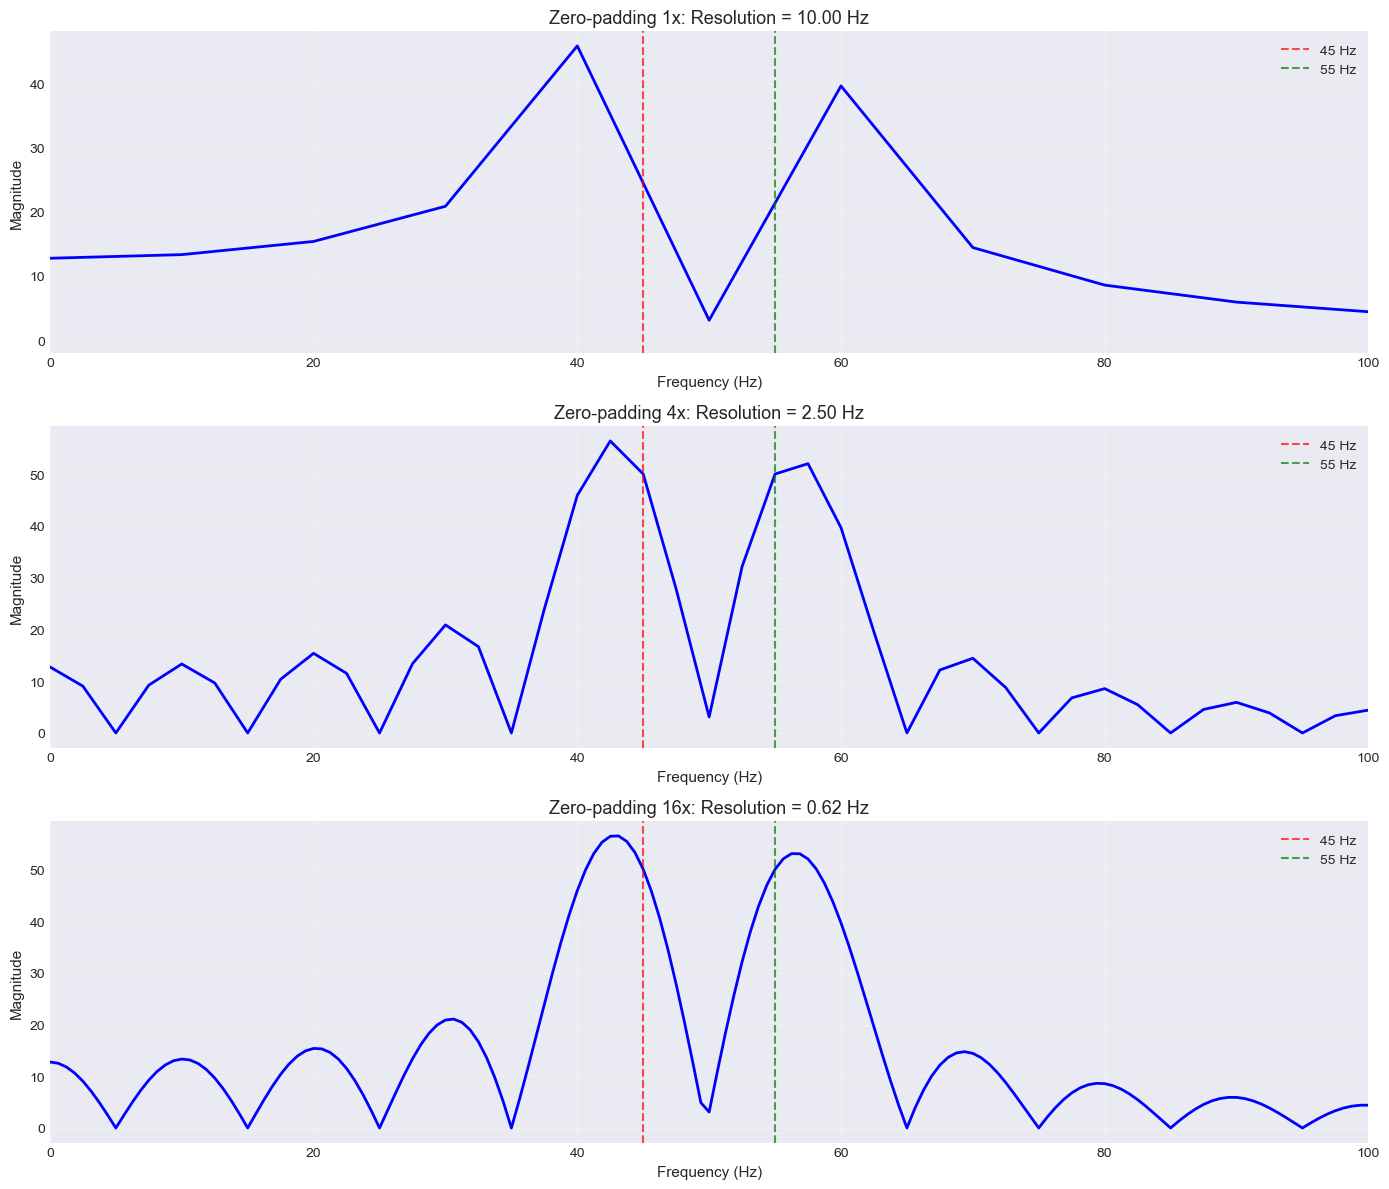

More zero-padding → smoother spectrum, easier to see both peaks!


In [4]:
# Create short signal with two close frequencies
sample_rate = 1000
duration = 0.1  # Very short: 100 samples
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Two frequencies close together: 45 Hz and 55 Hz
freq1, freq2 = 45, 55
signal = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)

N = len(signal)

print("Zero-Padding for Better Resolution")
print(f"  Signal length: {N} samples")
print(f"  Duration: {duration} s")
print(f"  Frequencies: {freq1} Hz and {freq2} Hz (10 Hz apart)")
print(f"  Original resolution: {sample_rate/N:.1f} Hz\n")

# FFT with different padding
padding_factors = [1, 4, 16]

fig, axes = plt.subplots(len(padding_factors), 1, figsize=(14, 12))

for i, factor in enumerate(padding_factors):
    N_padded = N * factor
    
    # FFT with zero-padding
    fft_padded = fft.fft(signal, n=N_padded)
    freqs_padded = fft.fftfreq(N_padded, 1/sample_rate)
    
    resolution = sample_rate / N_padded
    
    print(f"Padding factor {factor}x:")
    print(f"  Length: {N_padded}")
    print(f"  Resolution: {resolution:.2f} Hz")
    print(f"  Can separate {freq1} and {freq2}? {10/resolution > 2}\n")
    
    # Plot positive frequencies only
    positive_mask = freqs_padded >= 0
    axes[i].plot(freqs_padded[positive_mask], np.abs(fft_padded[positive_mask]), 
                 'b-', linewidth=2)
    axes[i].axvline(freq1, color='r', linestyle='--', alpha=0.7, label=f'{freq1} Hz')
    axes[i].axvline(freq2, color='g', linestyle='--', alpha=0.7, label=f'{freq2} Hz')
    axes[i].set_xlim(0, 100)
    axes[i].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[i].set_ylabel('Magnitude', fontsize=11)
    axes[i].set_title(f'Zero-padding {factor}x: Resolution = {resolution:.2f} Hz', fontsize=13)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("More zero-padding → smoother spectrum, easier to see both peaks!")

## Window Functions: Reduce Spectral Leakage

**Problem**: Finite signal length creates discontinuities
- FFT assumes signal is periodic
- Abrupt start/end → spectral leakage (energy spreads)
- False frequencies appear

**Solution**: Window functions smooth edges

**Common windows**:
- **Rectangular** (no window): w[n] = 1
- **Hann**: w[n] = 0.5(1 - cos(2πn/N))
- **Hamming**: w[n] = 0.54 - 0.46cos(2πn/N)
- **Blackman**: More complex, better suppression

**Trade-off**: Reduced leakage ↔ Wider main lobe

**Usage**: Multiply signal by window before FFT

Window Functions for Spectral Leakage
  Frequency: 50.5 Hz (non-integer)
  Duration: 1.0 s
  This creates 50.5 cycles → discontinuity at ends



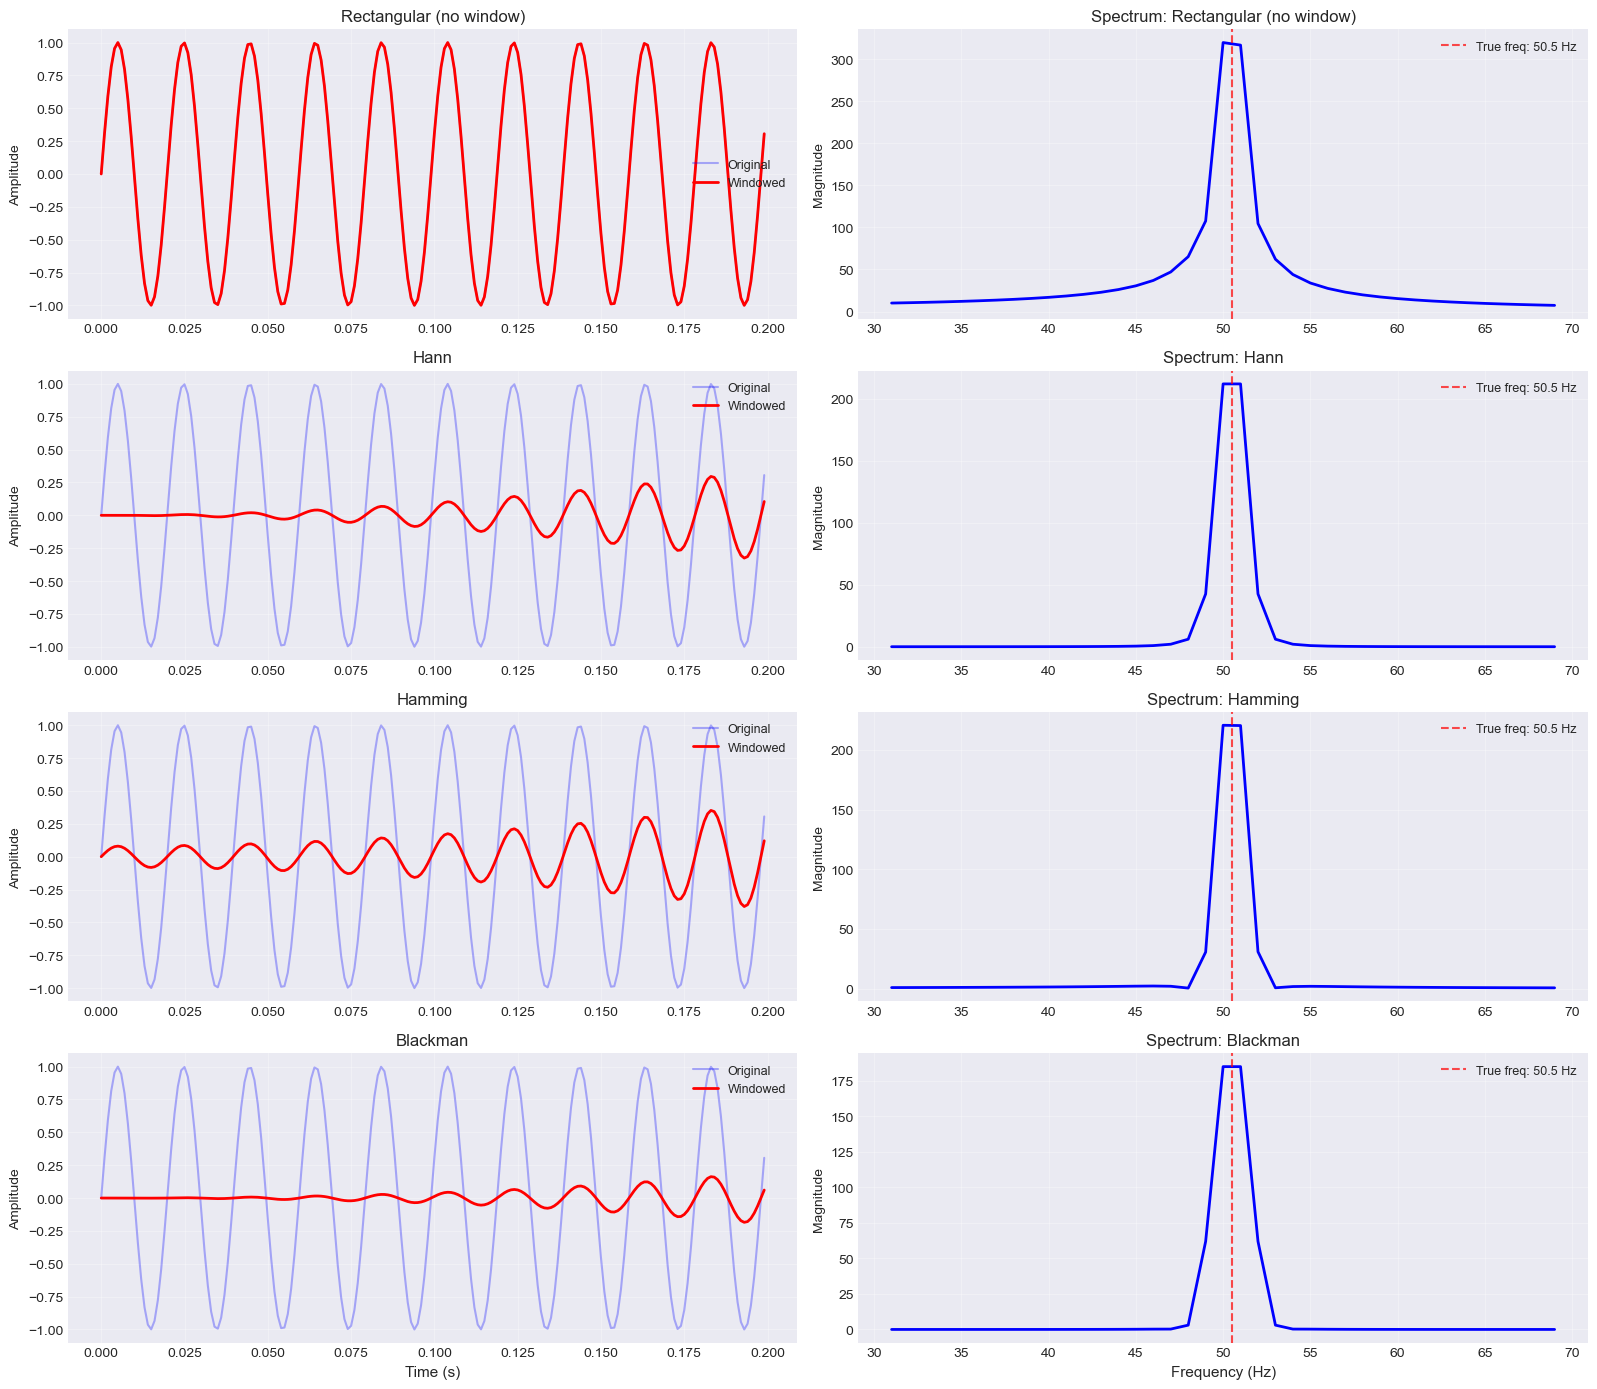

Windows reduce spectral leakage but widen the main peak
Rectangular (no window) has narrowest peak but most leakage
Blackman has best leakage suppression but widest peak


In [5]:
# Create signal with exact integer number of cycles
sample_rate = 1000
duration = 1.0
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# 50.5 Hz - NOT integer number of cycles → spectral leakage
frequency = 50.5
signal = np.sin(2*np.pi*frequency*t)

print("Window Functions for Spectral Leakage")
print(f"  Frequency: {frequency} Hz (non-integer)")
print(f"  Duration: {duration} s")
print(f"  This creates {frequency * duration} cycles → discontinuity at ends\n")

# Different windows
windows = {
    'Rectangular (no window)': np.ones(len(t)),
    'Hann': np.hanning(len(t)),
    'Hamming': np.hamming(len(t)),
    'Blackman': np.blackman(len(t))
}

fig, axes = plt.subplots(len(windows), 2, figsize=(16, 14))

for i, (name, window) in enumerate(windows.items()):
    # Apply window
    windowed_signal = signal * window
    
    # FFT
    fft_result = fft.fft(windowed_signal)
    freqs = fft.fftfreq(len(signal), 1/sample_rate)
    magnitude = np.abs(fft_result)
    
    # Time domain
    axes[i,0].plot(t[:200], signal[:200], 'b-', alpha=0.3, label='Original')
    axes[i,0].plot(t[:200], windowed_signal[:200], 'r-', linewidth=2, label='Windowed')
    axes[i,0].set_ylabel('Amplitude', fontsize=10)
    axes[i,0].set_title(f'{name}', fontsize=12)
    axes[i,0].legend(fontsize=9)
    axes[i,0].grid(True, alpha=0.3)
    
    # Frequency domain (zoom around peak)
    freq_range = (freqs > 30) & (freqs < 70)
    axes[i,1].plot(freqs[freq_range], magnitude[freq_range], 'b-', linewidth=2)
    axes[i,1].axvline(frequency, color='r', linestyle='--', alpha=0.7, 
                     label=f'True freq: {frequency} Hz')
    axes[i,1].set_ylabel('Magnitude', fontsize=10)
    axes[i,1].set_title(f'Spectrum: {name}', fontsize=12)
    axes[i,1].legend(fontsize=9)
    axes[i,1].grid(True, alpha=0.3)

axes[-1,0].set_xlabel('Time (s)', fontsize=11)
axes[-1,1].set_xlabel('Frequency (Hz)', fontsize=11)

plt.tight_layout()
plt.show()

print("Windows reduce spectral leakage but widen the main peak")
print("Rectangular (no window) has narrowest peak but most leakage")
print("Blackman has best leakage suppression but widest peak")

## Performance: FFT Size Optimization

**FFT complexity**: O(N log N)

**Best performance**: N = 2^k (power of 2)
- FFT algorithms optimized for powers of 2
- Can be 2-3x faster than arbitrary N

**Good sizes**: Products of small primes (2, 3, 5)
- N = 2^a × 3^b × 5^c
- Examples: 120, 128, 150, 256, 512, 1000

**Bad sizes**: Large prime numbers
- N = 1021, 2011, 4999
- Much slower

**Helper**: `scipy.fft.next_fast_len(N)` finds optimal size

FFT Performance vs Size

Size     Time (ms)    Fast?    next_fast_len
1000     0.014        No       1000
1024     0.011        Yes      1024
2000     0.012        No       2000
2048     0.011        Yes      2048
4000     0.021        No       4000
4096     0.025        Yes      4096
5000     0.026        No       5000
8192     0.045        Yes      8192

Example: Optimal padding
  Original signal size: 1000
  Optimal FFT size: 1000
  Speedup expected: ~2x by padding to 1000


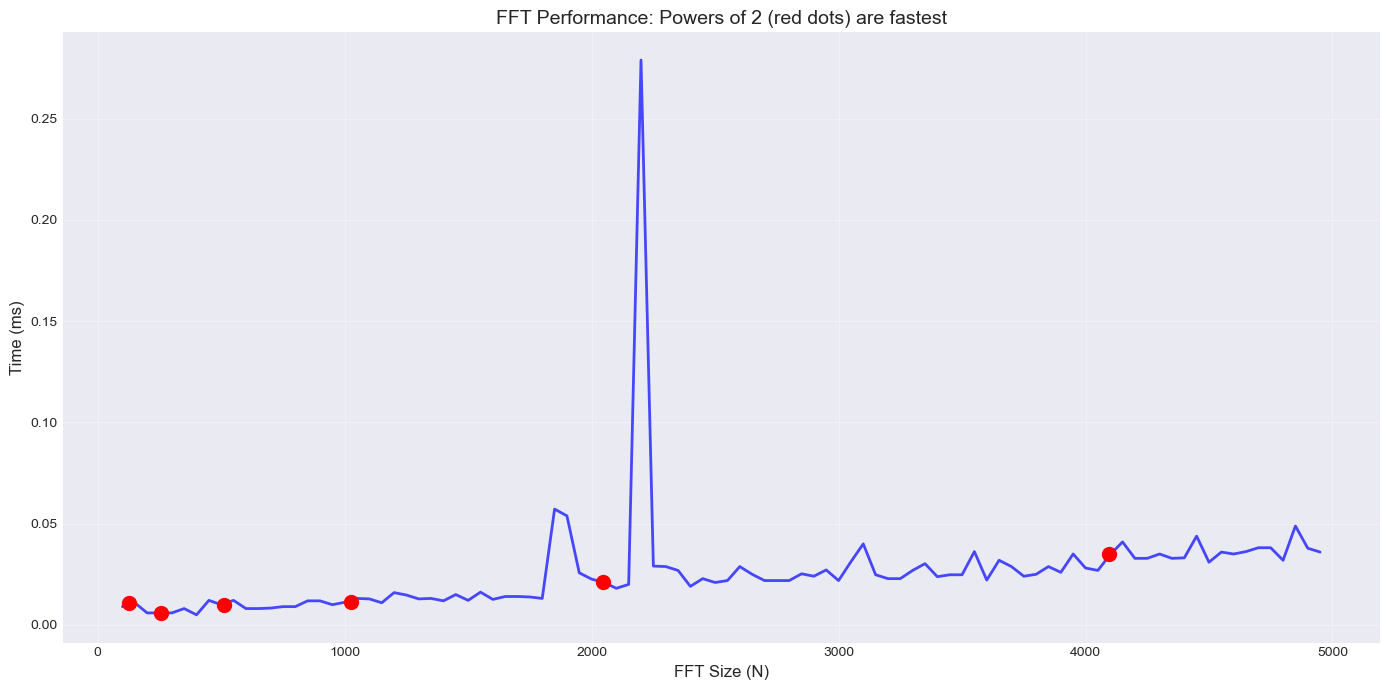


Always use next_fast_len() when padding for better performance!


In [6]:
# Test FFT performance for different sizes
test_sizes = [1000, 1024, 2000, 2048, 4000, 4096, 5000, 8192]

print("FFT Performance vs Size\n")
print(f"{'Size':<8} {'Time (ms)':<12} {'Fast?':<8} {'next_fast_len'}")
print("="*50)

for size in test_sizes:
    # Create random signal
    signal = np.random.randn(size)
    
    # Time FFT (multiple runs for accuracy)
    n_runs = 100
    t0 = time.time()
    for _ in range(n_runs):
        _ = fft.fft(signal)
    elapsed = (time.time() - t0) / n_runs * 1000  # ms
    
    # Check if power of 2
    is_power_of_2 = (size & (size - 1)) == 0
    
    # Get next fast length
    next_fast = fft.next_fast_len(size)
    
    print(f"{size:<8} {elapsed:<12.3f} {'Yes' if is_power_of_2 else 'No':<8} {next_fast}")

# Example: Using next_fast_len
signal_size = 1000
optimal_size = fft.next_fast_len(signal_size)

print(f"\nExample: Optimal padding")
print(f"  Original signal size: {signal_size}")
print(f"  Optimal FFT size: {optimal_size}")
print(f"  Speedup expected: ~2x by padding to {optimal_size}")

# Visualize size vs time
sizes = np.arange(100, 5000, 50)
times = []

for size in sizes:
    signal = np.random.randn(size)
    t0 = time.time()
    _ = fft.fft(signal)
    times.append((time.time() - t0) * 1000)

plt.figure(figsize=(14, 7))
plt.plot(sizes, times, 'b-', linewidth=2, alpha=0.7)

# Mark powers of 2
powers_of_2 = [128, 256, 512, 1024, 2048, 4096]
powers_of_2 = [p for p in powers_of_2 if p < 5000]
for p in powers_of_2:
    idx = np.argmin(np.abs(sizes - p))
    plt.plot(p, times[idx], 'ro', markersize=10)

plt.xlabel('FFT Size (N)', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.title('FFT Performance: Powers of 2 (red dots) are fastest', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAlways use next_fast_len() when padding for better performance!")

## Summary: Best Practices

### When to Use What:

| Function | When to Use |
|----------|-------------|
| `fft()` | Complex signals, two-sided spectrum needed |
| `rfft()` | Real signals (most common), faster |
| `fft2()` | 2D data (images) |
| `fftn()` | 3D or higher dimensions |

### Optimization Checklist:

✓ **Use rfft() for real signals** (2x faster, half memory)  
✓ **Pad to power of 2** or use `next_fast_len()` (2-3x faster)  
✓ **Apply window function** to reduce spectral leakage  
✓ **Use fftshift()** for visualization and filtering  
✓ **Zero-pad** for smoother spectrum (better plots)  

### Common Workflow:

```python
# 1. Apply window to reduce leakage
windowed = signal * np.hanning(len(signal))

# 2. Pad to optimal size
n = fft.next_fast_len(len(signal))

# 3. Use rfft for real signals
F = fft.rfft(windowed, n=n)
freqs = fft.rfftfreq(n, d=1/sample_rate)

# 4. Analyze magnitude
magnitude = np.abs(F)
```

### Memory Efficiency:

- **rfft**: N/2+1 complex values (real signals)
- **fft**: N complex values
- **2D rfft2**: (M × N/2+1) complex

### Key Helper Functions:

```python
fft.fftfreq(n, d)       # Frequency array
fft.rfftfreq(n, d)      # Real FFT frequencies
fft.fftshift(x)         # Center DC component
fft.ifftshift(x)        # Undo shift
fft.next_fast_len(n)    # Optimal FFT size
```